In [1]:
hmargs = {
    'aprx': 'paca',
    'basis': 'linear',
    'admis': '2',
    'eta': 1.2,
#     'eps': 0,
    'm': 4,
    'clf': 32,
    'eps_aca': 1e-3,     
    'rk': 0,
    'q_reg': 2,
    'q_sing': 4,
    'strict': True,
}
refn = 9
freqs = 0, 10e6, 1e6
c = 1500
rho = 1000
eps_lu = 1e-12

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy.linalg import norm
from cnld.h2lib import matrixnorms

from cnld import abstract, fem, bem, mesh
from cnld.arrays import matrix_array
from cnld.compressed_formats import MbkSparseMatrix

array = matrix_array(nelem=[1,1], shape='circle')
fs = np.arange(freqs[0], freqs[1] + freqs[2], freqs[2])

amesh = mesh.Mesh.from_abstract(array, refn)
ob = amesh.on_boundary
F = np.array(fem.array_f_spmatrix(array, refn).todense())
b = np.sum(F, axis=1)

nrmse = np.zeros(len(fs))

for i, f in enumerate(tqdm(fs)):
    
    omg = 2 * np.pi * f
    k = omg / c
    
    Zfm = bem.array_z_matrix(array, refn, k, format='FullFormat', **hmargs)
    Zhm = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
    
    err = matrixnorms.norm2diff_amatrix_hmatrix(Zhm._mat, Zfm._mat) / norm(Zfm.data)
    nrmse[i] = err
    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, nrmse)


100%|██████████| 11/11 [00:30<00:00,  2.74s/it]


100%|██████████| 2/2 [00:15<00:00,  7.97s/it]


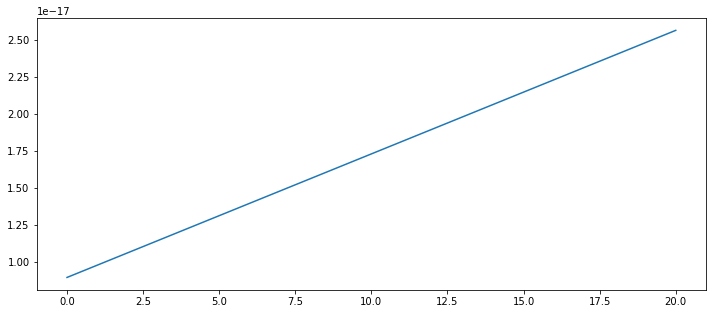

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy.linalg import norm
from cnld.h2lib import matrixnorms

from cnld import abstract, fem, bem, mesh
from cnld.arrays import matrix_array
from cnld.compressed_formats import MbkSparseMatrix

array = matrix_array(nelem=[1,2], shape='square')
fs = np.arange(freqs[0], freqs[1] + freqs[2], freqs[2])

amesh = mesh.Mesh.from_abstract(array, refn)
ob = amesh.on_boundary
F = np.array(fem.array_f_spmatrix(array, refn).todense())
b = np.sum(F, axis=1)

nrmse = np.zeros(len(fs))
xfm_mean = np.zeros(len(fs))
xhm_mean = np.zeros(len(fs))

for i, f in enumerate(tqdm(fs)):
    
    omg = 2 * np.pi * f
    k = omg / c
    
    Gfe = fem.array_mbk_spmatrix(array, refn, f)
    Zfm = bem.array_z_matrix(array, refn, k, format='FullFormat', **hmargs)
    Zhm = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
    Zhm.eps_add = 1e-12
    
    Gfm = MbkSparseMatrix(Gfe) + -omg**2 * 2 * rho * Zfm
    Ghm = MbkSparseMatrix(Gfe) + -omg**2 * 2 * rho * Zhm
    
    err = matrixnorms.norm2diff_amatrix_hmatrix(Ghm._mat, Gfm._mat) / norm(Gfm.data)
    nrmse[i] = err

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, nrmse)

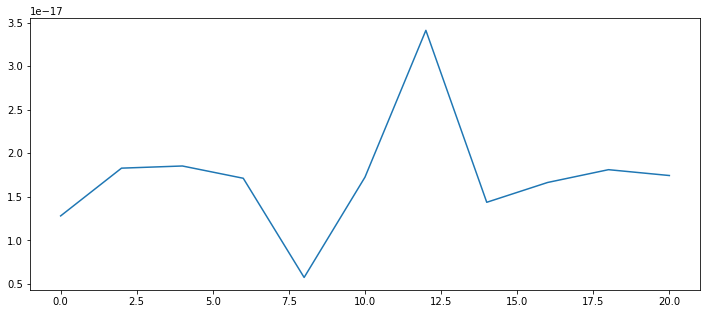

In [3]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, nrmse)

100%|██████████| 51/51 [10:42<00:00, 13.13s/it]


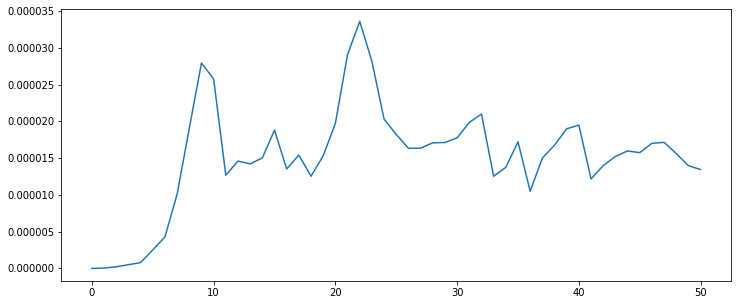

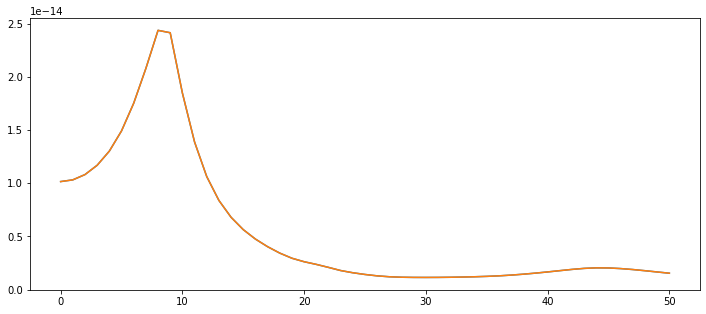

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy.linalg import norm
from cnld.h2lib import matrixnorms

from cnld import abstract, fem, bem, mesh
from cnld.arrays import matrix_array
from cnld.compressed_formats import MbkSparseMatrix

array = matrix_array(nelem=[1,3], shape='circle')
fs = np.arange(freqs[0], freqs[1] + freqs[2], freqs[2])

amesh = mesh.Mesh.from_abstract(array, refn)
ob = amesh.on_boundary
F = np.array(fem.array_f_spmatrix(array, refn).todense())
b = np.sum(F, axis=1)

nrmse = np.zeros(len(fs))
xfm_mean = np.zeros(len(fs))
xhm_mean = np.zeros(len(fs))

for i, f in enumerate(tqdm(fs)):
    
    omg = 2 * np.pi * f
    k = omg / c
    
    Gfe = fem.array_mbk_spmatrix(array, refn, f)
    Zfm = bem.array_z_matrix(array, refn, k, format='FullFormat', **hmargs)
    Zhm = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
    
    Gfm = MbkSparseMatrix(Gfe) + -omg**2 * 2 * rho * Zfm
    Ghm = MbkSparseMatrix(Gfe) + -omg**2 * 2 * rho * Zhm
    Gfm.eps_lu = eps_lu
    Ghm.eps_lu = eps_lu
    
    xfm = np.conj(Gfm.lu().lusolve(b))
    xfm[ob] = 0
    xhm = np.conj(Ghm.lu().lusolve(b))
    xhm[ob] = 0
    
    xfm_mean[i] = np.mean(np.abs(xfm))
    xhm_mean[i] = np.mean(np.abs(xhm))
    nrmse[i] = norm(xfm - xhm) / norm(xfm)

    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, nrmse)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, xfm_mean)
ax.plot(fs / 1e6, xhm_mean)

In [1]:
hmargs = {
    'aprx': 'paca',
    'basis': 'linear',
    'admis': '2',
    'eta': 1.2,
    'm': 4,
    'clf': 32,
    'eps_aca': 1e-3,     
    'rk': 0,
    'q_reg': 2,
    'q_sing': 4,
    'strict': True,
}
refn = 9

import numpy as np
from matplotlib import pyplot as plt
import sys

from cnld import abstract, fem, bem, mesh
from cnld.arrays import matrix_array


array = matrix_array(nelem=[1,1], shape='circle')
amesh = mesh.Mesh.from_abstract(array, refn)
ob = amesh.on_boundary
F = np.array(fem.array_f_spmatrix(array, refn).todense())
b = np.sum(F, axis=1)

k = 2 * np.pi * 1e6 / 1500
Zhm = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
h = Zhm._mat


def _draw_hmatrix(hm, bbox, maxidx, lvl):
    print(lvl)
    sys.stdout.flush()
    if len(hm.son) == 0:
        if hm.r:
#             rk = str(hm.r.k)
            fill = False
        elif hm.f:
            rk = None
            fill = True
        else:
            raise Exception
    else:
#         rmax, cmax = maxidx
#         x0, y0, x1, y1 = bbox

#         rsidx = (0, 1, 0, 1)
#         csidx = (0, 0, 1, 1)

#         width0 = len(hm.son[0].cc.idx) / cmax
#         height0 = len(hm.son[0].rc.idx) / rmax
        
        for i, s in enumerate(hm.son):
#             width = len(s.cc.idx) / cmax
#             height = len(s.rc.idx) / rmax

#             xnew = x0 if csidx[i] == 0 else x0 + width0
#             ynew = y0 if rsidx[i] == 0 else y0 + height0

#             if csidx[i] == 0: 
#                 xnew = x0
#             else: 
#                 xnew = x0 + width0
#             if rsidx[i] == 0:
#                 ynew = y0
#             else:
#                 ynew = y0 + height0

#             bbox = xnew, ynew, xnew + width, ynew + height
            _draw_hmatrix(s, bbox, maxidx, lvl + 1)

            
def draw(hm):
    
    maxidx = len(hm.rc.idx), len(hm.cc.idx)
    _draw_hmatrix(hm, (0, 0, 1, 1), maxidx, 0)

# draw(h)